# Test simulating compendia by random sampling

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import umap
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)


import warnings
warnings.filterwarnings(action='ignore')

from ponyo import utils, train_vae_modules, simulate_expression_data

Using TensorFlow backend.


In [2]:
# Set seeds to get reproducible VAE trained models
train_vae_modules.set_all_seeds()

In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_filename = os.path.abspath(os.path.join(base_dir,
                                           "human_tests", 
                                           "config_test_human.tsv"))
params = utils.read_config(config_filename)

In [4]:
# Load parameters
base_dir = params["base_dir"]
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
analysis_name = params["simulation_type"]
train_architecture = params['NN_architecture']
num_simulated_samples = params['num_simulated_samples']
rpkm_data_filename = params["raw_data_filename"]
normalized_data_filename = params["normalized_data_filename"]
training_stats_dir = params["training_stats_dir"]
vae_model_dir = params["vae_model_dir"]

In [5]:
# Input files
assert os.path.exists(rpkm_data_filename)

## Setup directories

In [6]:
utils.setup_dir(config_filename)

In [7]:
# Check that directories were made correctly
assert os.path.isdir(training_stats_dir)
assert os.path.isdir(vae_model_dir)

## Pre-process data

In [8]:
train_vae_modules.normalize_expression_data(config_filename,
                                            rpkm_data_filename,
                                            normalized_data_filename)

input: dataset contains 273 samples and 5000 genes
Output: normalized dataset contains 273 samples and 5000 genes


## Train VAE

input dataset contains 273 samples and 5000 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 246 samples, validate on 27 samples
Epoch 1/10
246/246 [==============================] - 22s 91ms/step - loss: 2340.0547 - kl_loss: 13.9695 - recons_loss: 2340.0549 - val_loss: 2576.0480 - val_kl_loss: 138.0642 - val_recons_loss: 2576.0481
Epoch 2/10
246/246 [==============================] - 21s 86ms/step - loss: 2167.1981 - kl_loss: 13.5955 - recons_loss: 2167.1982 - val_loss: 2336.0543 - val_kl_loss: 77.9998 - val_recons_loss: 2336.0542
Epoch 3/10
246/246 [==============================] - 22s 89ms/step - loss: 2154.3693 - kl_loss: 13.6479 - recons_loss: 2154.3691 - val_loss: 2209.4096 - val_kl_loss: 48.1001 - val_recons_loss: 2209.4097
Epoch 4/10
246/246 [==============================] 

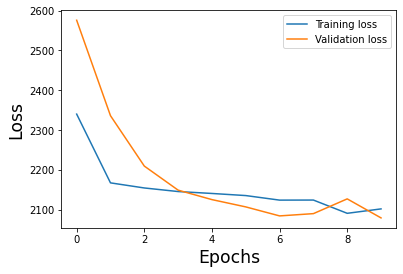

In [9]:
# Train VAE
train_vae_modules.train_vae(config_filename,
                            normalized_data_filename)

In [10]:
# Check reproducibility of VAE training
template_path = "data/test_vae_log.tsv"
output_path = "logs/tybalt_2layer_30latent_stats.tsv"
assert pd.read_csv(output_path, sep="\t")["val_loss"].values[-1] < 2800, pd.read_csv(output_path, sep="\t")["val_loss"].values[-1]

## Simulate data by random sampling

In [11]:
# Run simulation
simulated_data = simulate_expression_data.simulate_by_random_sampling(
    normalized_data_filename,
    num_simulated_samples,
    vae_model_dir,
)

Normalized gene expression data contains 273 samples and 5000 genes
Return: simulated gene expression data containing 100 samples and 5000 genes


In [12]:
simulated_data.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.047630,0.036323,0.277738,0.119633,0.284286,0.346632,0.020977,0.096944,0.062515,0.418223,...,0.425015,0.361483,0.352412,0.020304,0.385193,0.157354,0.041844,0.049361,0.546658,0.421452
1,0.105216,0.041911,0.326393,0.190275,0.330326,0.358407,0.049109,0.164491,0.118614,0.475839,...,0.401023,0.417316,0.386674,0.045546,0.385735,0.247026,0.101031,0.080914,0.595254,0.265012
2,0.044584,0.052045,0.256216,0.125644,0.321328,0.339894,0.025672,0.089412,0.070641,0.389407,...,0.376761,0.370860,0.451509,0.024428,0.305814,0.152770,0.044391,0.052519,0.548577,0.277092
3,0.213337,0.090136,0.331925,0.146207,0.348609,0.224303,0.078291,0.206755,0.176637,0.438614,...,0.411843,0.415836,0.401190,0.055254,0.388872,0.261685,0.179475,0.102899,0.560416,0.235998
4,0.210298,0.179365,0.256450,0.219491,0.295060,0.208946,0.125192,0.166322,0.183197,0.408472,...,0.346551,0.352284,0.299130,0.072374,0.329897,0.240977,0.141765,0.070050,0.497483,0.220044


## Visualize random sampled compendium

In [13]:
# Read data
normalized_data = pd.read_csv(normalized_data_filename, header=0, sep="\t", index_col=0)

In [14]:
normalized_data.head()

,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000119953.12,ENSG00000119965.12,ENSG00000119969.14,ENSG00000119973.5,ENSG00000119977.20,ENSG00000119979.16,ENSG00000119986.6,ENSG00000120008.15,ENSG00000120029.12,ENSG00000120049.18
SRR493816,0.192519,0.0,0.214496,0.030213,0.185058,0.002518,0.037827,0.132201,0.344856,0.222818,...,0.098992,0.294837,0.061220,0.000000,0.302188,0.119891,0.279795,0.024098,0.650383,0.022837
SRR493817,0.127613,0.0,0.191400,0.022873,0.148562,0.003878,0.001635,0.103004,0.406601,0.187205,...,0.132431,0.312500,0.089187,0.003215,0.275055,0.139419,0.919693,0.026674,1.000000,0.039663
SRR547975,0.122846,0.0,0.483292,0.030554,0.324603,0.000000,0.064989,0.391202,0.035818,0.801450,...,1.000000,0.576087,0.506717,0.000000,0.509190,0.282016,0.124300,0.018504,0.598180,0.126202
SRR547973,0.407407,0.0,0.316953,0.067338,0.308716,0.000000,0.000000,0.106436,0.353394,0.209581,...,0.201964,0.387228,0.085444,0.000000,0.144639,0.187557,0.044633,1.000000,0.430077,0.006010
SRR547968,0.078108,0.0,0.173464,0.038576,0.200086,0.000000,0.000000,0.463940,0.239900,0.570123,...,0.419321,0.585598,0.641268,0.000000,1.000000,0.341962,0.157735,0.023676,0.687739,0.080529


In [15]:
model = umap.UMAP(random_state=123).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])

In [16]:
# UMAP embedding of simulated data

simulated_data_UMAPencoded = model.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

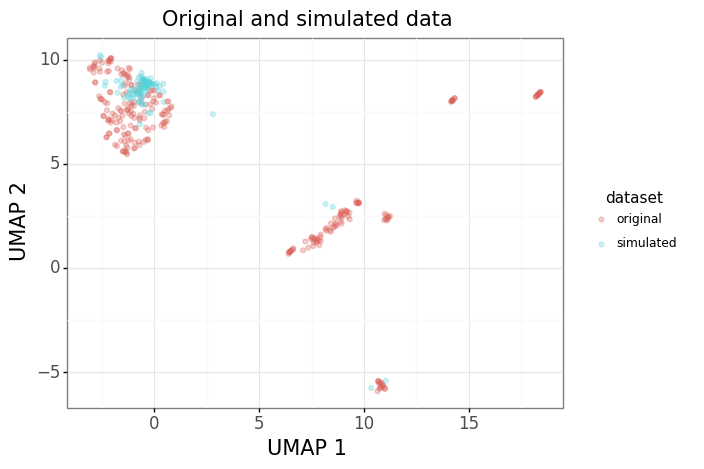

<ggplot: (8768742074725)>


In [17]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
g_input_sim = ggplot(combined_data_df, aes(x='1', y='2'))
g_input_sim += geom_point(aes(color='dataset'),alpha=0.3)
g_input_sim += labs(x = "UMAP 1",
                    y = "UMAP 2", 
                    title = "Original and simulated data")
g_input_sim += theme_bw()
g_input_sim += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)

)

print(g_input_sim)